In [1]:
import os
import glob
from typing import List, Tuple, Optional
import numpy as np
import torch as t

import torch
import ipywidgets as widgets
from IPython.display import display, HTML
import plotly.express as px
import pandas as pd
from transformers import AutoTokenizer

In [2]:
import numpy as np

def ce_from_logits_np(logits: np.ndarray, target_id, reduction: str = "mean"):
    """
    logits: array of shape (V,) or (B, V)
    target_id: int or array of shape () or (B,)
    reduction: "none" | "mean" | "sum"
    """
    logits = np.asarray(logits)
    single = logits.ndim == 1
    if single:
        logits = logits[None, :]

    targets = np.asarray(target_id, dtype=np.int64)
    if targets.ndim == 0 and logits.shape[0] > 1:
        targets = np.full((logits.shape[0],), targets, dtype=np.int64)

    max_logits = logits.max(axis=-1, keepdims=True)
    x = logits - max_logits
    logsumexp = np.log(np.exp(x).sum(axis=-1)) + max_logits.squeeze(-1)

    batch_indices = np.arange(logits.shape[0])
    correct = logits[batch_indices, targets]
    loss = logsumexp - correct

    if reduction == "none":
        return loss if not single else loss[0]
    if reduction == "sum":
        return loss.sum()
    return loss.mean()


import torch

def ce_from_logits_t(logits: torch.Tensor, target_id, reduction: str = "mean") -> torch.Tensor:
    """
    Cross-entropy from logits (numerically stable).
    - logits: (V,) or (B, V)
    - target_id: int or LongTensor shape () or (B,)
    - returns: scalar (mean) by default; or per-sample if reduction='none'
    """
    single = logits.ndim == 1
    if single:
        logits = logits.unsqueeze(0)

    targets = torch.as_tensor(target_id, device=logits.device, dtype=torch.long)
    if targets.ndim == 0:
        targets = targets.expand(logits.shape[0])

    logsumexp = torch.logsumexp(logits, dim=-1)
    correct = logits.gather(dim=-1, index=targets.view(-1, 1)).squeeze(-1)
    loss = logsumexp - correct

    if reduction == "none":
        return loss[0] if single else loss
    if reduction == "sum":
        return loss.sum()
    return loss.mean()

In [3]:
# Configuration
DEFAULT_DIR = "bad_samples_logits"
DEFAULT_TOKENIZER = "gpt2"

# Discover files
def list_pt_files(directory: str) -> List[str]:
    pattern = os.path.join(directory, "*.pt")
    files = sorted(glob.glob(pattern))
    return files

# Load a single saved sample

def load_sample(path: str):
    data = torch.load(path, map_location="cpu")
    logits = data["logits"]  # (1, seq_len, vocab) or (seq_len, vocab)
    input_ids = data.get("input_ids")
    decoded = data.get("decoded")
    if logits.dim() == 2:
        logits = logits.unsqueeze(0)
    # Ensure input_ids has batch dim
    if input_ids is not None and input_ids.dim() == 1:
        input_ids = input_ids.unsqueeze(0)
    return logits, input_ids, decoded

# Build widgets
files_dd = widgets.Dropdown(options=list_pt_files(DEFAULT_DIR), description="File:", layout=widgets.Layout(width="70%"))
refresh_btn = widgets.Button(description="Refresh Files", button_style="info")

position_input = widgets.BoundedIntText(value=0, min=0, max=0, step=1, description="Position:")

k_slider = widgets.IntSlider(value=20, min=1, max=200, step=1, description="Top-k:", continuous_update=False)
show_table_chk = widgets.Checkbox(value=False, description="Show full table (slow)")

specific_token_txt = widgets.Text(value="", placeholder="token text or id", description="Token:")
lookup_btn = widgets.Button(description="Lookup Token", button_style="")

status_out = widgets.Output()
chart_out = widgets.Output()
table_out = widgets.Output()
lookup_out = widgets.Output()

# Tokenizer
TOKENIZER = AutoTokenizer.from_pretrained(DEFAULT_TOKENIZER)
TOKENIZER.pad_token = TOKENIZER.eos_token


def refresh_files(_=None):
    files_dd.options = list_pt_files(DEFAULT_DIR)


def update_position_bounds():
    if not files_dd.value:
        position_input.max = 0
        position_input.value = 0
        return
    logits, input_ids, _ = load_sample(files_dd.value)
    seq_len = logits.shape[1]
    position_input.max = max(0, seq_len - 1)
    position_input.value = min(position_input.value, position_input.max)


def render():
    status_out.clear_output()
    chart_out.clear_output()
    table_out.clear_output()
    if not files_dd.value:
        with status_out:
            print("No file selected")
        return

    logits, input_ids, decoded = load_sample(files_dd.value)
    seq_len, vocab = logits.shape[1], logits.shape[2]
    pos = position_input.value
    pos = max(0, min(pos, seq_len - 1))

    # Get logits for position
    pos_logits = logits[0, pos]  # (vocab,)
    probs = torch.softmax(pos_logits, dim=-1)

    # Top-k
    k = min(k_slider.value, vocab)
    topk_probs, topk_idx = torch.topk(probs, k)
    topk_tokens = [TOKENIZER.decode([int(i)]) for i in topk_idx]

    df = pd.DataFrame({
        "token_id": topk_idx.detach().cpu().numpy(),
        "token": topk_tokens,
        "prob": topk_probs.detach().cpu().numpy(),
        "logit": pos_logits[topk_idx].detach().cpu().numpy(),
    })

    with status_out:
        print(f"Loaded: {files_dd.value}")
        print(f"Sequence length: {seq_len}, Vocab size: {vocab}")
        if input_ids is not None:
            print(f"Input ids len: {input_ids.shape[1]}")
        if decoded is not None and isinstance(decoded, str) and len(decoded) > 0:
            print(f"Decoded (truncated): {decoded[:120]}...")

    with chart_out:
        fig = px.bar(df.iloc[::-1], x="prob", y="token", orientation="h", hover_data=["token_id", "logit"], title=f"Top-{k} probabilities at position {pos}")
        fig.update_layout(height=600)
        display(fig)

    if show_table_chk.value:
        full_df = pd.DataFrame({
            "token_id": range(vocab),
            "token": [TOKENIZER.decode([i]) for i in range(vocab)],
            "prob": probs.detach().cpu().numpy(),
            "logit": pos_logits.detach().cpu().numpy(),
        }).sort_values("prob", ascending=False)
        with table_out:
            display(full_df)


def on_lookup(_=None):
    lookup_out.clear_output()
    if not files_dd.value:
        return
    logits, _, _ = load_sample(files_dd.value)
    seq_len = logits.shape[1]
    pos = position_input.value
    pos = max(0, min(pos, seq_len - 1))
    pos_logits = logits[0, pos]

    query = specific_token_txt.value.strip()
    if not query:
        return

    # accept token id
    idx: Optional[int] = None
    if query.isdigit():
        idx = int(query)
    else:
        # try encode single token; tokenizer may split
        ids = TOKENIZER.encode(query, add_special_tokens=False)
        if len(ids) == 1:
            idx = ids[0]
        else:
            # fallback to first piece
            idx = ids[0] if len(ids) > 0 else None
    if idx is None:
        with lookup_out:
            print("Could not map token")
        return

    logit = float(pos_logits[idx])
    prob = float(torch.softmax(pos_logits, dim=-1)[idx])
    with lookup_out:
        print(f"Token id: {idx}")
        print(f"Token text: {TOKENIZER.decode([idx])!r}")
        print(f"Logit: {logit:.6f}")
        print(f"Prob: {prob:.6f}")


# Wire up events
refresh_btn.on_click(refresh_files)
files_dd.observe(lambda change: update_position_bounds() or render(), names="value")
position_input.observe(lambda change: render(), names="value")
k_slider.observe(lambda change: render(), names="value")
show_table_chk.observe(lambda change: render(), names="value")
lookup_btn.on_click(on_lookup)

# Initial population
refresh_files()
update_position_bounds()
render()

# Layout
controls = widgets.VBox([
    widgets.HBox([files_dd, refresh_btn]),
    position_input,
    widgets.HBox([k_slider, show_table_chk]),
    widgets.HBox([specific_token_txt, lookup_btn]),
])

ui = widgets.VBox([
    controls,
    status_out,
    chart_out,
    table_out,
    widgets.HTML("<hr/>"),
    widgets.HTML("<b>Token Lookup</b>"),
    lookup_out,
])

display(ui)


/tmp/ipykernel_24859/604938764.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location="cpu")


In [57]:
import torch
import matplotlib.pyplot as plt

def load_sample(path: str):
    data = torch.load(path, map_location="cpu")
    logits = data["logits"]  # (1, seq_len, vocab) or (seq_len, vocab)
    input_ids = data.get("input_ids")
    decoded = data.get("decoded")
    if logits.dim() == 2:
        logits = logits.unsqueeze(0)
    # Ensure input_ids has batch dim
    if input_ids is not None and input_ids.dim() == 1:
        input_ids = input_ids.unsqueeze(0)
    return logits, input_ids, decoded

def load_sample_resid(path: str):
    data = torch.load(path, map_location="cpu")
    logits = data["logits"]  # (1, seq_len, vocab) or (seq_len, vocab)
    input_ids = data.get("input_ids")
    decoded = data.get("decoded")
    resid_norm = data.get("resid_norm")
    if logits.dim() == 2:
        logits = logits.unsqueeze(0)
    # Ensure input_ids has batch dim
    if input_ids is not None and input_ids.dim() == 1:
        input_ids = input_ids.unsqueeze(0)
    return logits, input_ids, decoded, resid_norm

def plot_logit_dist(tensor, title=""):
    # Option A: histogram over all values
    vals = tensor.detach().cpu().flatten().numpy()
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=400, density=False, log=False)
    plt.title(title)
    plt.xlabel("Value"); plt.ylabel("Density")
    plt.tight_layout(); plt.show()

def plot_logit_at_pos(tensor, pos):
    # Option B: histogram at a specific position (e.g., last position)
    pos_logits = tensor[0, pos].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.hist(pos_logits, bins=400, density=False)
    plt.title(f"Histogram at pos {pos}")
    plt.xlabel("Logit"); plt.ylabel("Density")
    plt.tight_layout(); plt.show()
    
def plot_logit_at_pos(tensor: torch.Tensor, pos: int, correct_token_id: int, bins: int = 400, density: bool = False):
    """
    tensor: logits of shape (B, T, V); this plots histogram over V at batch 0, position pos
    correct_token_id: int, the target token id at this position
    """
    pos_logits = tensor[0, pos].detach().float().cpu().numpy()  # (V,)
    correct_logit = float(pos_logits[correct_token_id])

    plt.figure(figsize=(6, 4))
    plt.hist(pos_logits, bins=bins, density=density)
    plt.axvline(correct_logit, color='r', linestyle='--', linewidth=1.8,
                label=f'correct id={correct_token_id}, logit={correct_logit:.3f}')
    plt.title(f"Histogram at pos {pos}")
    plt.xlabel("Logit"); plt.ylabel("Density" if density else "Count")
    plt.legend()
    plt.tight_layout(); plt.show()

def load_high_loss_sample(path="high_loss_sample_1.txt"):
    """
    Parses 'token:loss' pairs from the file, returns:
      - max_idx: index where loss is highest (ignoring NaNs like 'N/A')
      - tokens: np.ndarray[int64]
      - losses: np.ndarray[float64]
    """
    with open(path, "r") as f:
        text = f.read().strip()

    pairs = [p.strip() for p in text.split(",")]
    tokens, losses = [], []
    for p in pairs:
        if not p:
            continue
        if ":" not in p:
            continue
        tok_str, loss_str = p.split(":", 1)
        try:
            tok = int(tok_str.strip())
        except ValueError:
            continue
        try:
            loss = float(loss_str.strip())
        except ValueError:
            loss = np.nan  # e.g., 'N/A'
        tokens.append(tok)
        losses.append(loss)

    tokens = np.asarray(tokens, dtype=np.int64)
    losses = np.asarray(losses, dtype=np.float64)

    if not np.isfinite(losses).any():
        raise ValueError("No finite losses found in file.")

    max_idx = np.nanargmax(losses)  # ignores NaNs
    return max_idx, tokens, losses

In [29]:
logits_1, input_ids_1, decoded_1 = load_sample('bad_samples_logits/high_loss_1.pt')
logits_2, input_ids_2, decoded_2 = load_sample('bad_samples_logits/high_loss_2.pt')
logits_3, input_ids_3, decoded_3 = load_sample('bad_samples_logits/high_loss_3.pt')
logits, input_ids, decoded = load_sample('bad_samples_logits/normal_sample.pt')

/tmp/ipykernel_24859/994900995.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_24859/2087477842.py:17: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



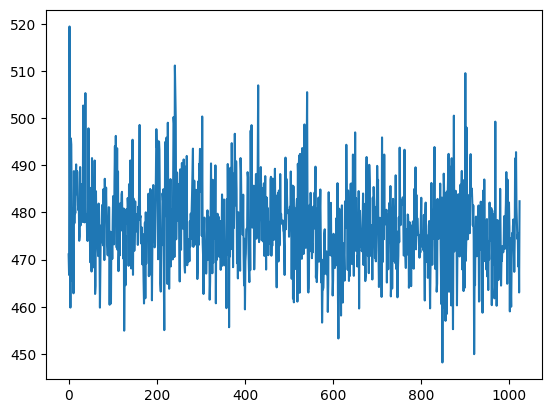

In [66]:
logits_1, input_ids_1, decoded_1, resid_1 = load_sample_resid('bad_samples_logits/normal_sample_wresid_norm.pt')
plt.plot(resid_1[0, :])
plt.show()

In [69]:
logits_1, input_ids_1, decoded_1, resid_1 = load_sample_resid('bad_samples_logits/high_loss_1_wresid_norm.pt')

/tmp/ipykernel_24859/2087477842.py:17: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



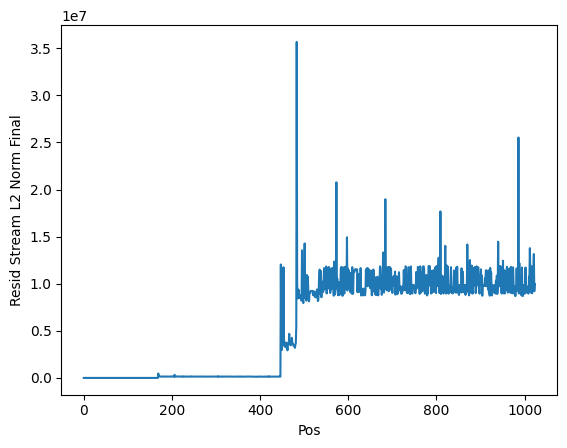

In [70]:
plt.plot(resid_1[0, :])
plt.ylabel('Resid Stream L2 Norm Final')
plt.xlabel('Pos')
plt.show()

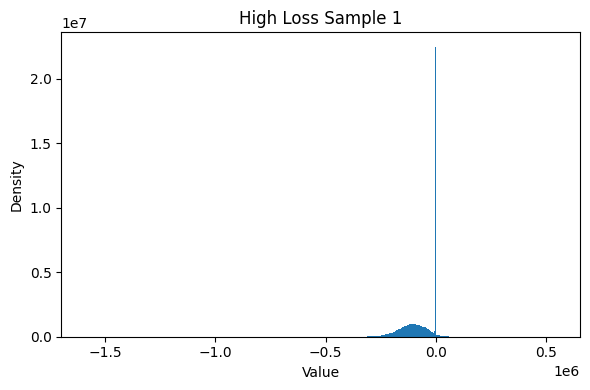

In [56]:
plot_logit_dist(logits_1[:, :, :], "High Loss Sample 1")

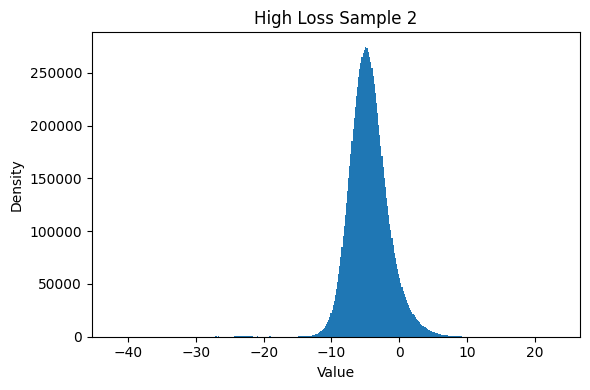

In [32]:
plot_logit_dist(logits_2, "High Loss Sample 2")

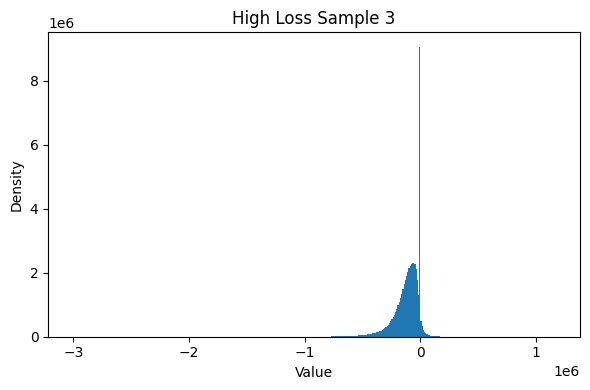

In [33]:
plot_logit_dist(logits_3, "High Loss Sample 3")

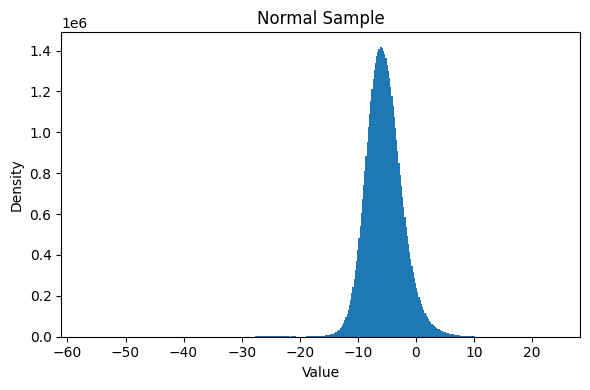

In [34]:
plot_logit_dist(logits, "Normal Sample")

In [12]:
# Need the specif location of the highest loss. need to print a line where the correct token is.

In [13]:
max_ids1, tokens1, losses1 = load_high_loss_sample('high_loss_sample_1.txt')
max_ids2, tokens2, losses2 = load_high_loss_sample('high_loss_sample_2.txt')
max_ids3, tokens3, losses3 = load_high_loss_sample('high_loss_sample_3.txt')
max_ids, tokens, losses = load_high_loss_sample('normal_loss_samples.txt')

In [14]:
def print_stats(logits, max_id, tokens, losses):
    print(f"logit at max loss token: {logits[0, max_id, tokens[max_id]]}")
    print(f"max loss: {losses[max_id]}")
    print(f"max_loss_token: {tokens[max_id]}")
    print(f"max_loss_pos: {max_id}")
    loss_logit_based = ce_from_logits_t(logits[0, max_id-1, :], tokens[max_id])
    print(f"loss_recalcualted: {loss_logit_based}")


import torch
from typing import List, Tuple

def print_infinite_positions(x: torch.Tensor, name: str = "tensor") -> List[Tuple[int, ...]]:
    """
    Prints all positions of +inf/-inf in x and returns the list of index tuples.
    """
    inf_mask = torch.isinf(x)
    num_inf = int(inf_mask.sum().item())
    if num_inf == 0:
        print(f"No infinite values found in {name}.")
        return []

    indices = inf_mask.nonzero(as_tuple=False)  # (N, x.ndim)
    print(f"Found {num_inf} infinite values in {name}:")
    for idx in indices.tolist():
        t_idx = tuple(idx)
        val = x[t_idx].item()
        print(f"  {t_idx}: {val}")
    return [tuple(idx.tolist()) for idx in indices]
print_infinite_positions(logits_1)
print_infinite_positions(logits_2)
print_infinite_positions(logits_3)
print_infinite_positions(logits)

No infinite values found in tensor.
No infinite values found in tensor.
No infinite values found in tensor.
No infinite values found in tensor.


[]

In [15]:
print_stats(logits_1, max_ids1, tokens1, losses1)

logit at max loss token: -563201.0625
max loss: 631761.9
max_loss_token: 200
max_loss_pos: 655
loss_recalcualted: 631958.0625


In [16]:
print_stats(logits_2, max_ids2, tokens2, losses2)

logit at max loss token: 4.091096878051758
max loss: 599915.1
max_loss_token: 3419
max_loss_pos: 131
loss_recalcualted: 2.379666328430176


In [17]:
print_stats(logits_3, max_ids3, tokens3, losses3)

logit at max loss token: -806741.1875
max loss: 5056170.0
max_loss_token: 197
max_loss_pos: 832
loss_recalcualted: 2441904.0


In [19]:
max_loss1 = ce_from_logits_t(logits_1[0, max_ids1-1, :], tokens1[max_ids1])
print(f"Max loss 1: {max_loss1}")
max_loss2 = ce_from_logits_t(logits_2[0, max_ids2-1, :], tokens2[max_ids2])
print(f"Max loss 2: {max_loss2}")
max_loss3 = ce_from_logits_t(logits_3[0, max_ids3-1, :], tokens3[max_ids3])
print(f"Max loss 3: {max_loss3}")


Max loss 1: 631958.0625
Max loss 2: 2.379666328430176
Max loss 3: 2441904.0


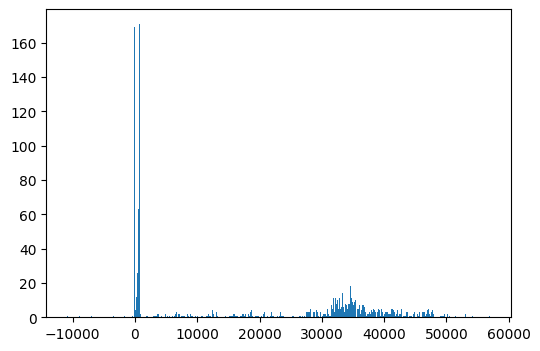

In [37]:
# plt.figure(figsize=(6,4))
# plt.hist(logits_1[0, 1, 0], bins=400, density=False)
# plt.show()

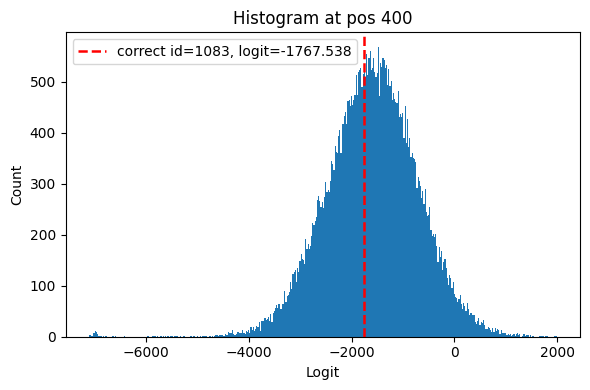

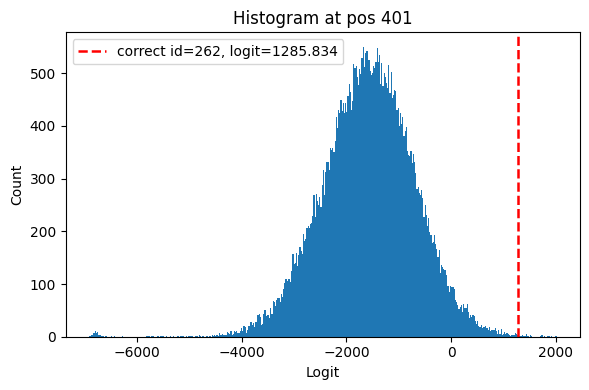

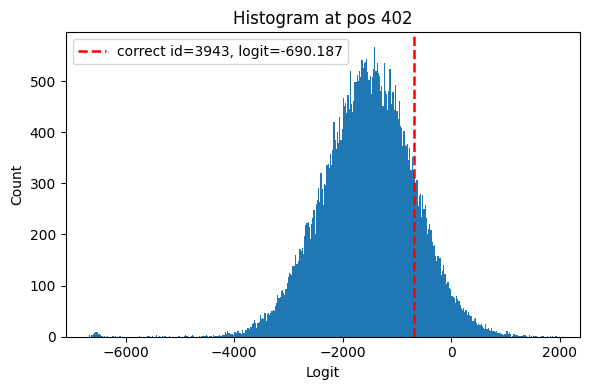

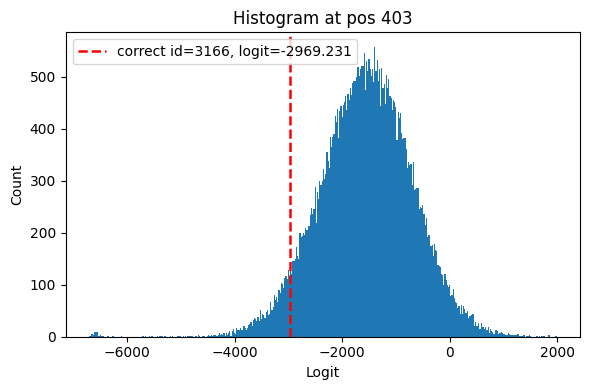

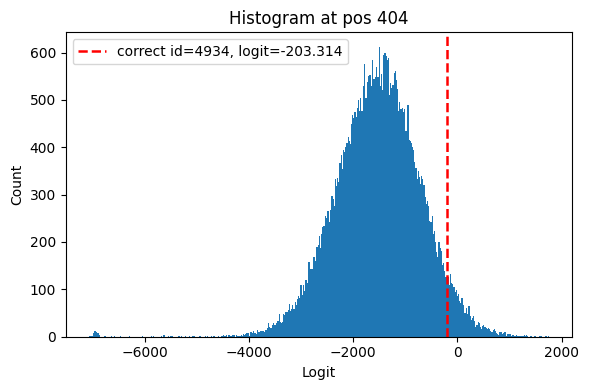

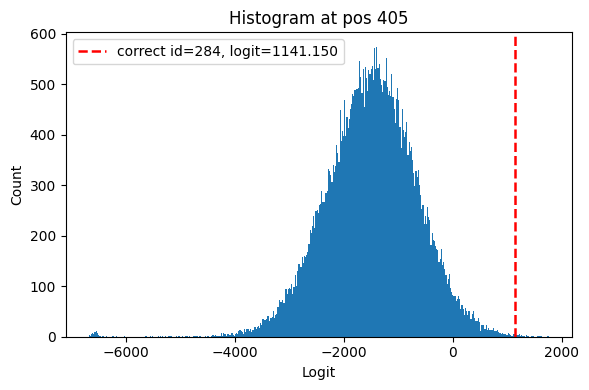

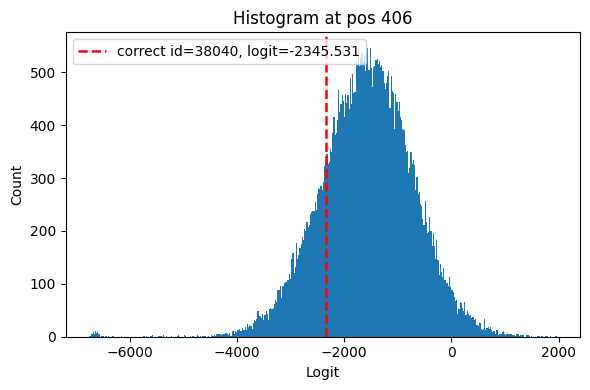

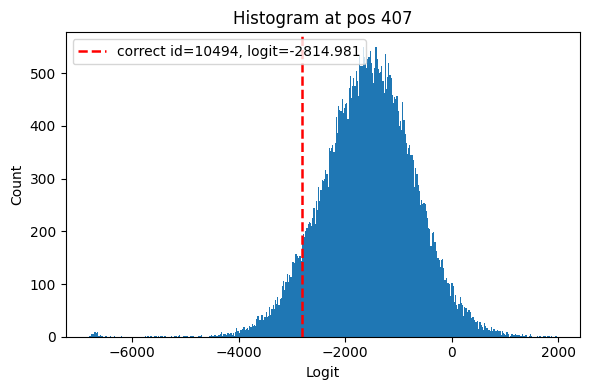

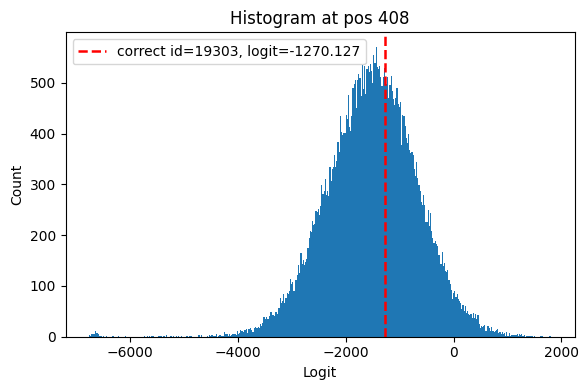

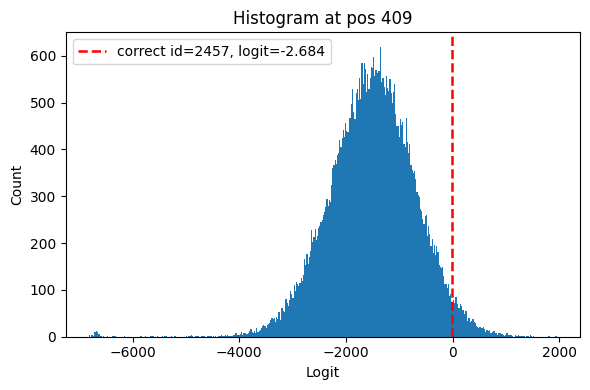

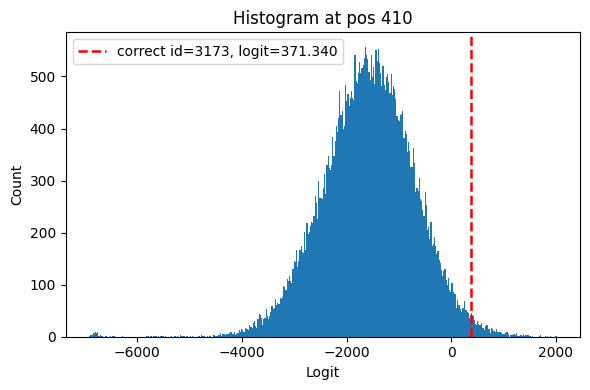

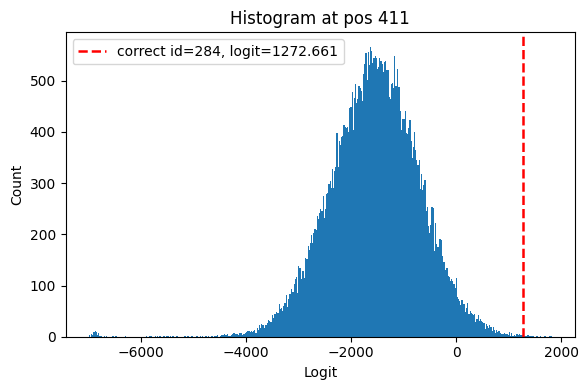

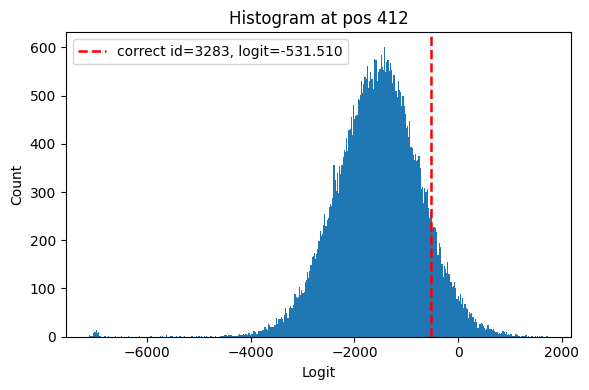

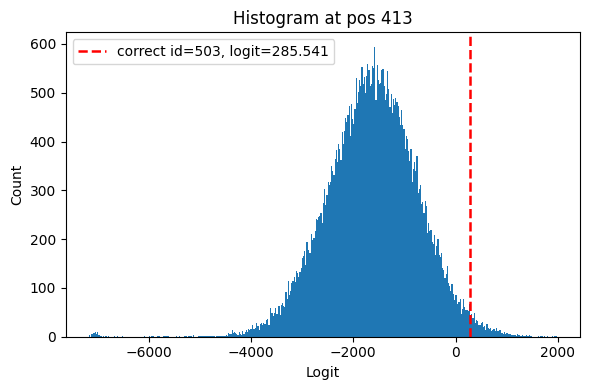

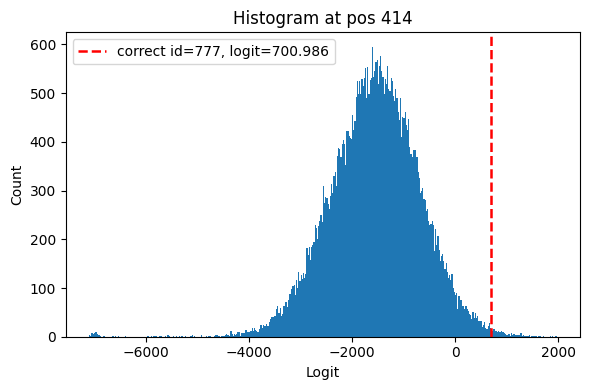

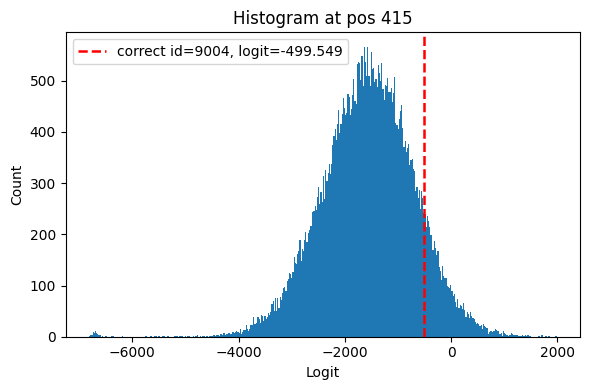

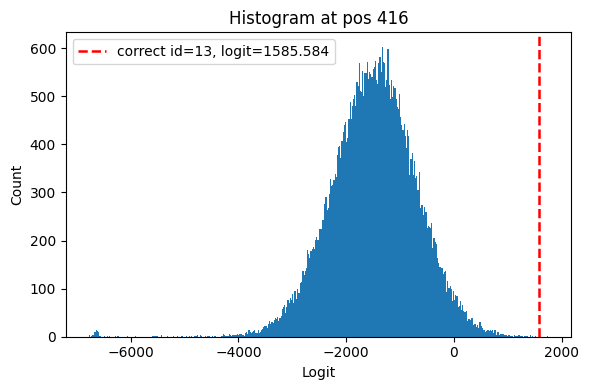

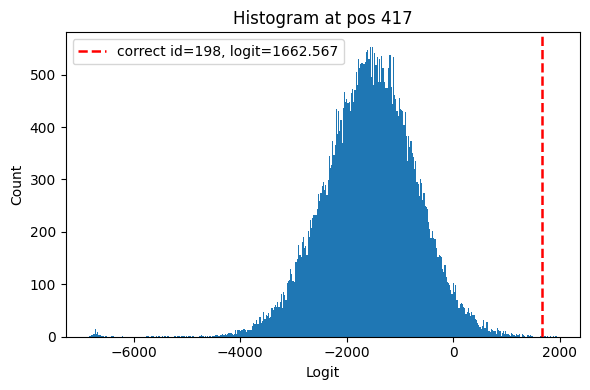

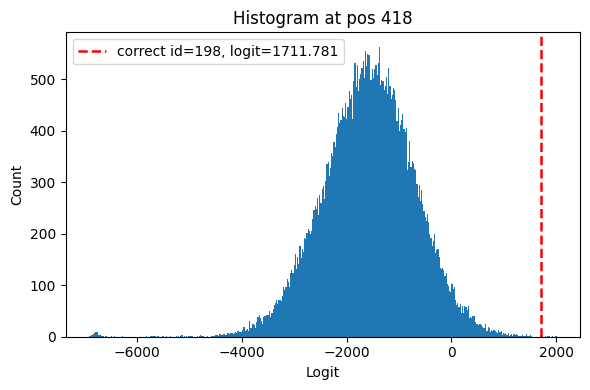

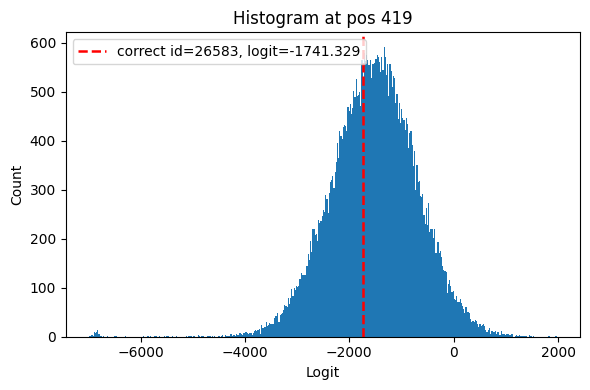

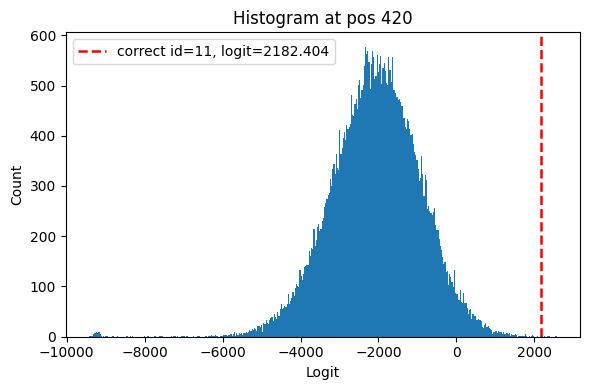

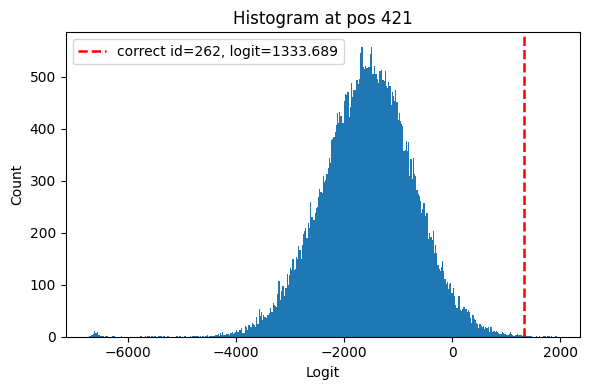

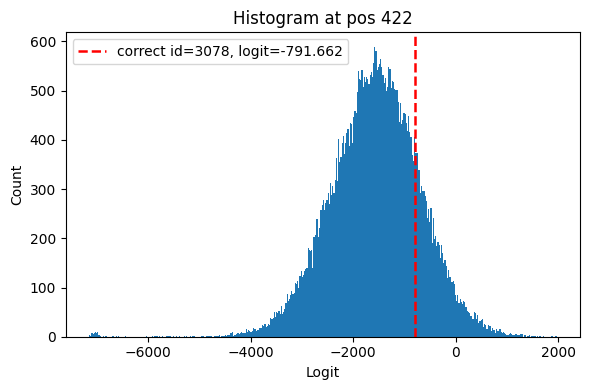

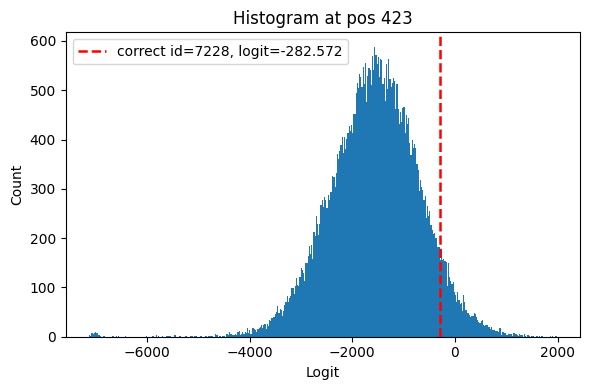

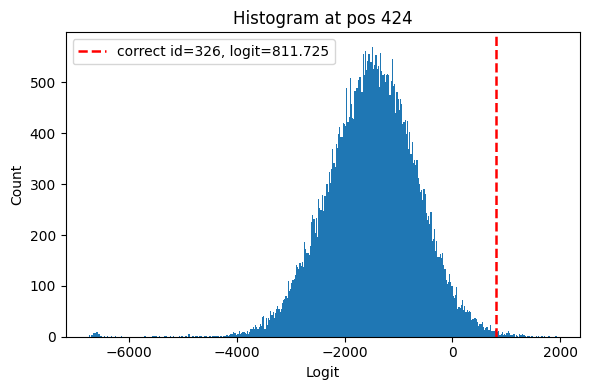

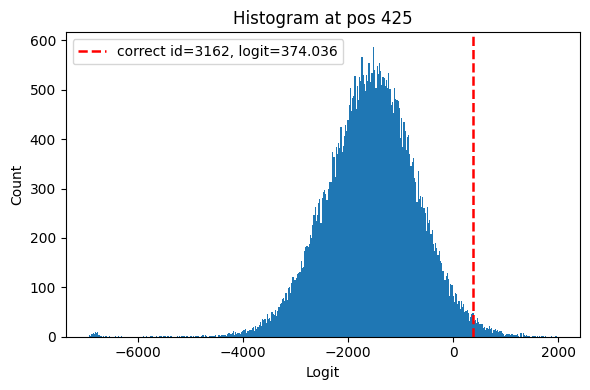

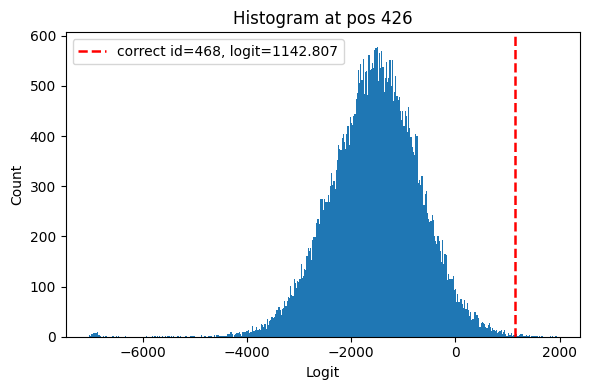

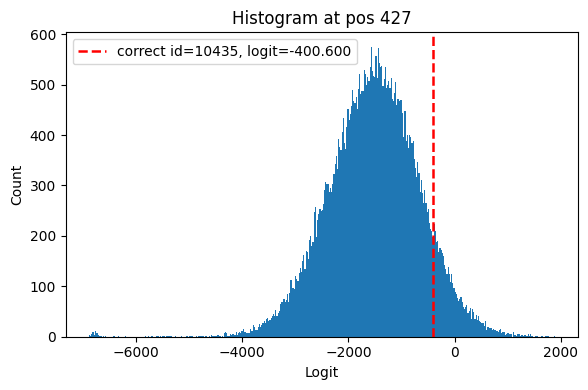

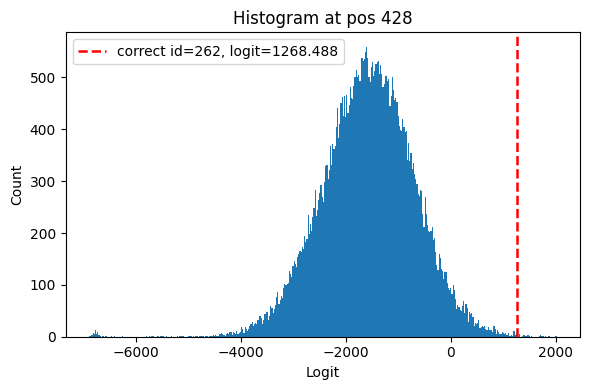

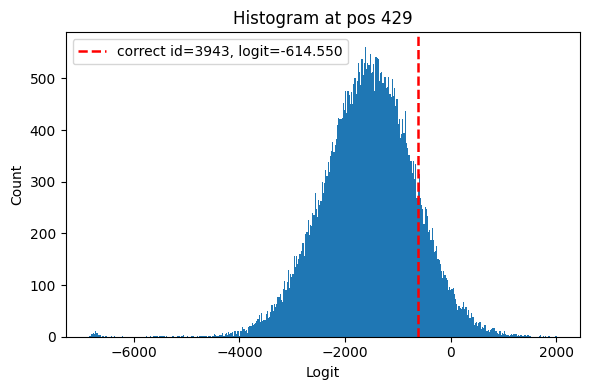

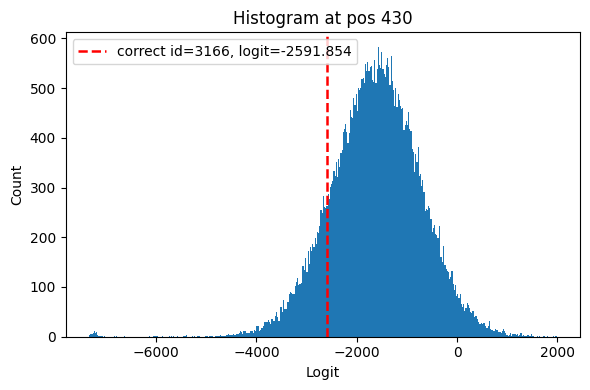

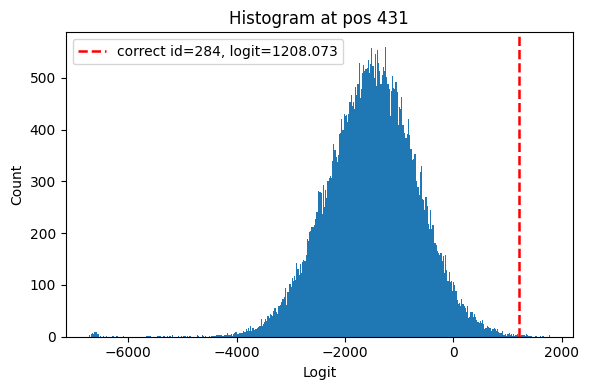

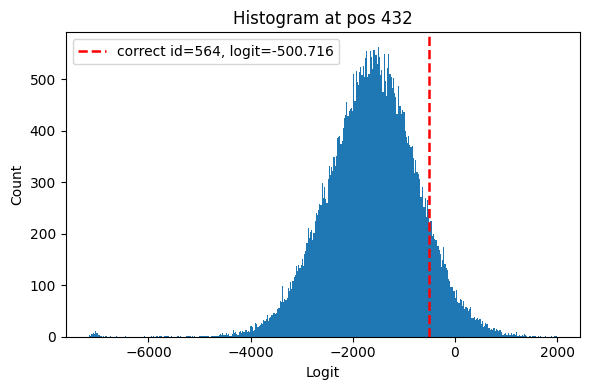

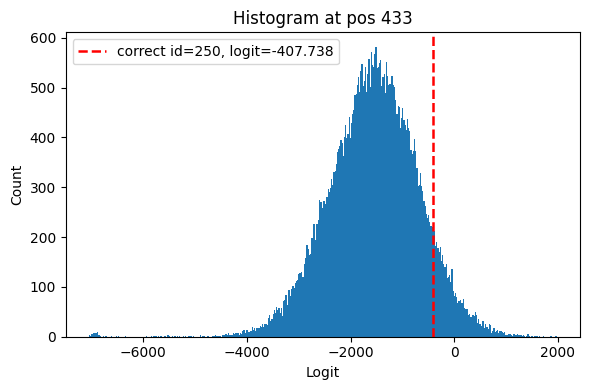

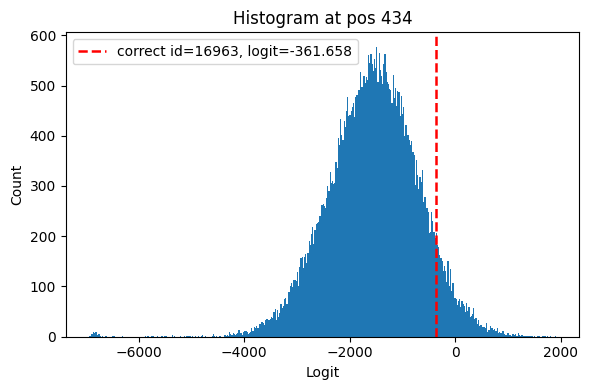

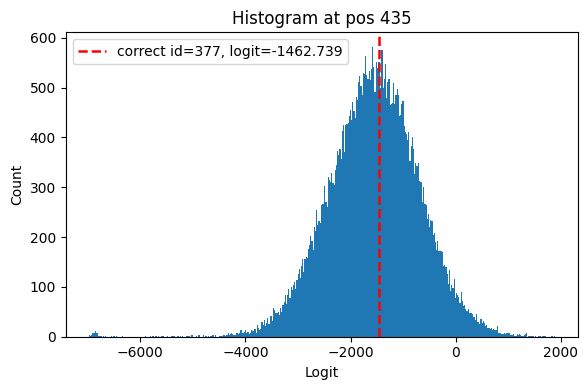

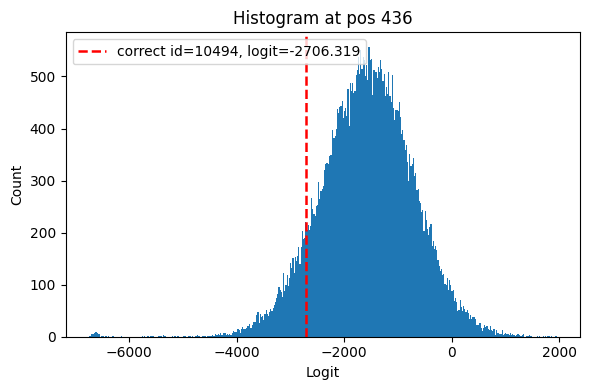

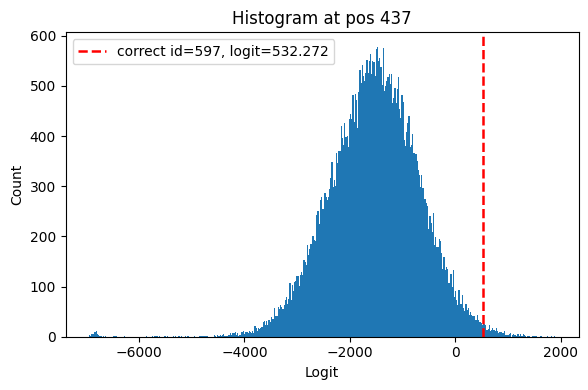

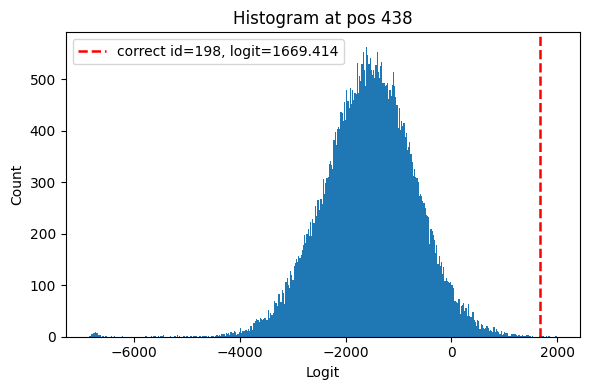

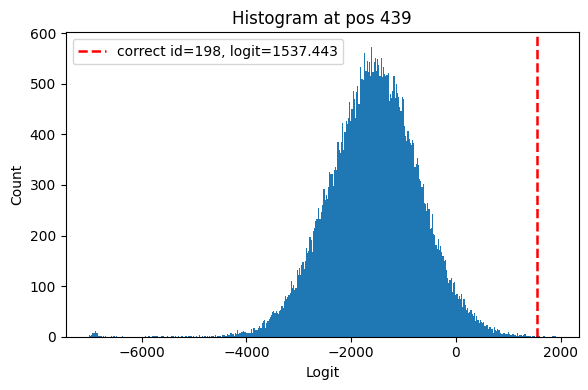

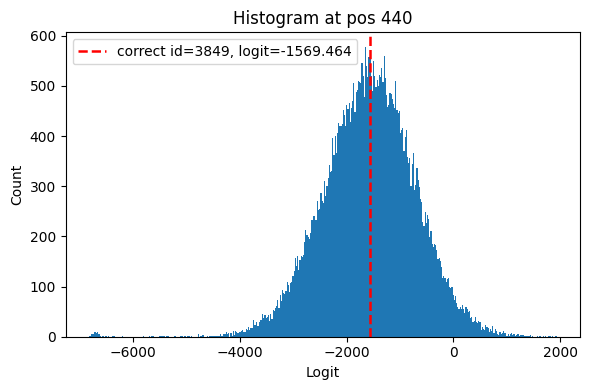

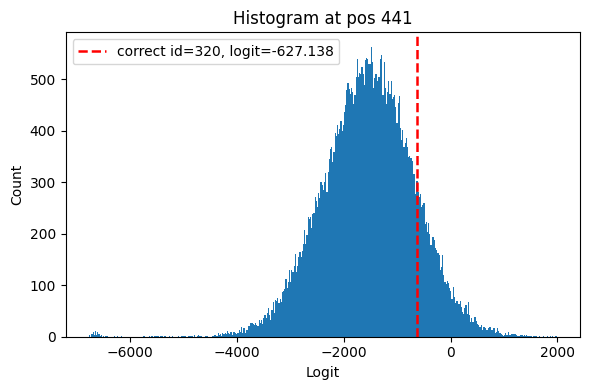

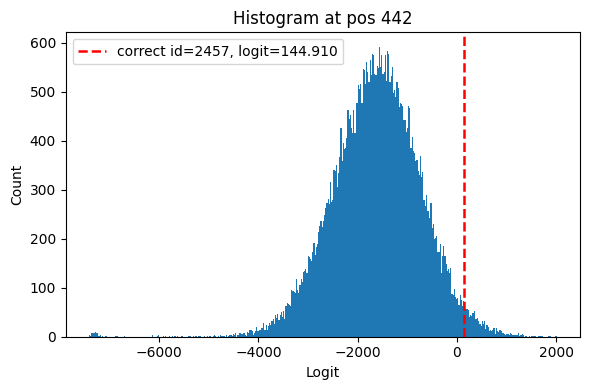

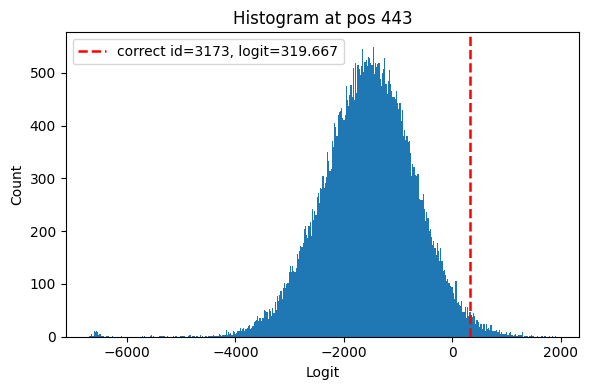

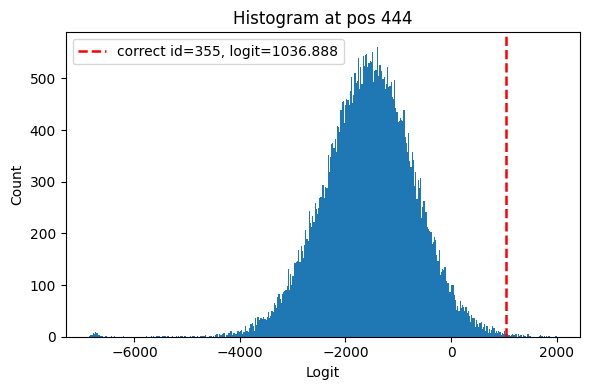

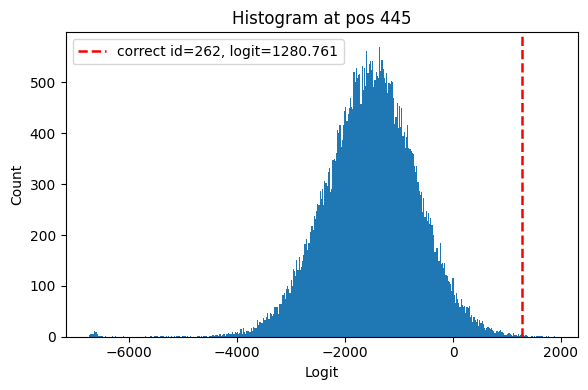

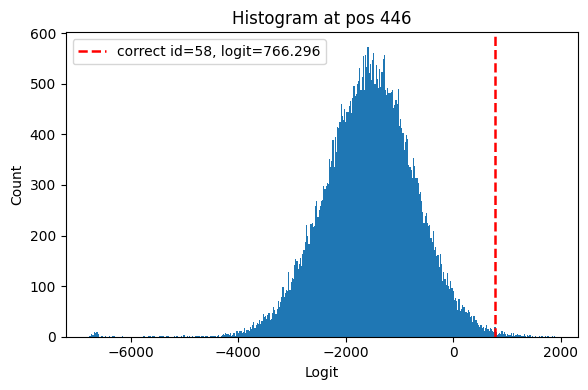

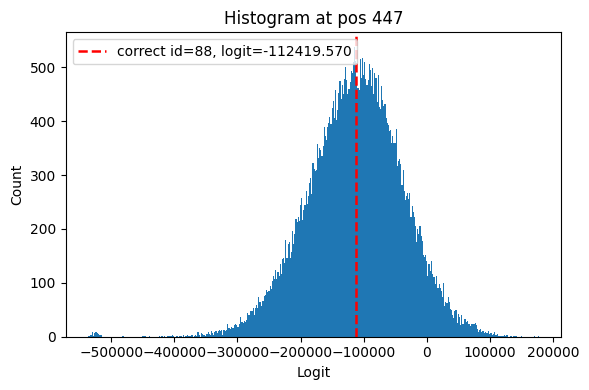

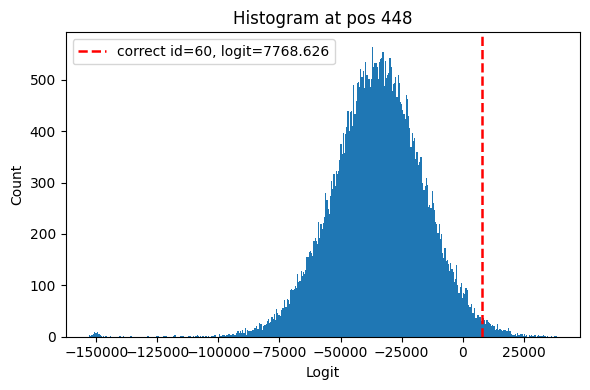

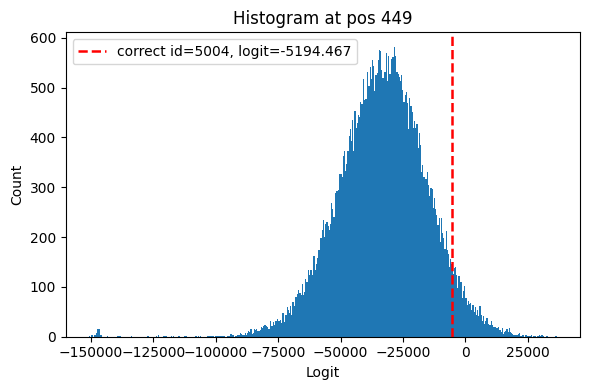

In [55]:
for i in range(400, 450):
    plot_logit_at_pos(logits_1, i, tokens1[i])

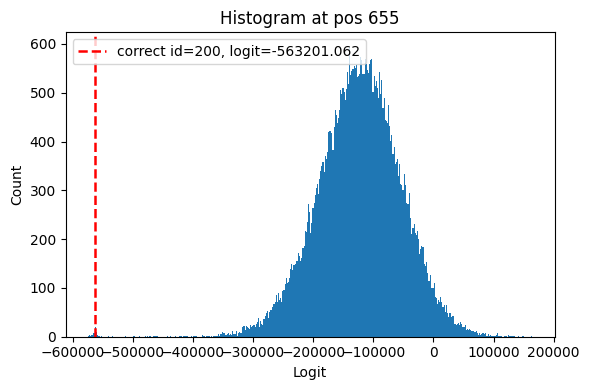

In [25]:
plot_logit_at_pos(logits_1, max_ids1, tokens1[max_ids1])


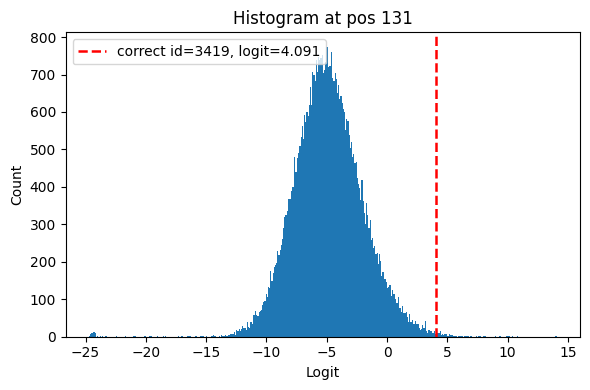

In [26]:
plot_logit_at_pos(logits_2, max_ids2, tokens2[max_ids2])

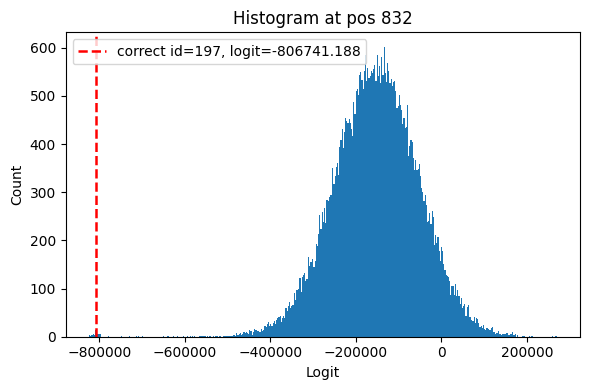

In [27]:
plot_logit_at_pos(logits_3, max_ids3, tokens3[max_ids3])

In [64]:
tokens2[max_ids2]

np.int64(7059)

In [62]:
logits_2[0, max_ids2, tokens2[max_ids2]]

tensor(0.2103)

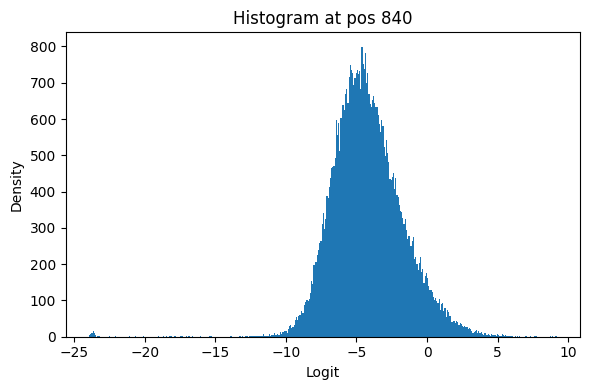

In [54]:
plot_logit_at_pos(logits_2, max_ids2)

In [63]:
logits_3[0, max_ids3, tokens3[max_ids3]]

tensor(-438538.0938)

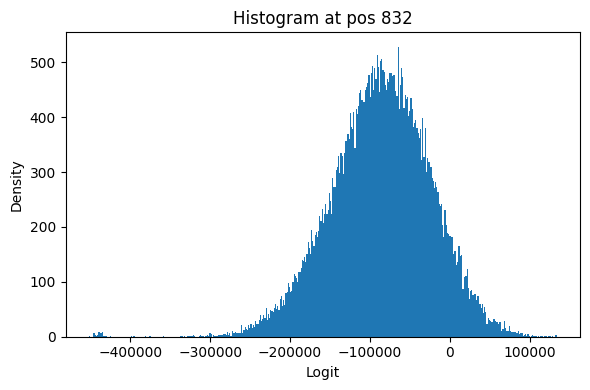

In [55]:
plot_logit_at_pos(logits_3, max_ids3)

In [37]:
max_ids2

np.int64(840)

In [41]:
for i in logits_2[0, max_ids2, :]:
    if i < -100:
        print(i)

In [29]:
print(np.exp(-617876.3125) / (1 + np.exp(-617876.3125)))

0.0


In [30]:
t.argmin(logits)

tensor(24274316)

In [31]:
min_val = logits.min()
flat_idx = logits.argmin()
pos = t.unravel_index(flat_idx, logits.shape)  # tuple of indices

In [32]:
print(min_val)

tensor(-617876.3125)


In [33]:
print(pos)

(tensor(0), tensor(483), tensor(185))


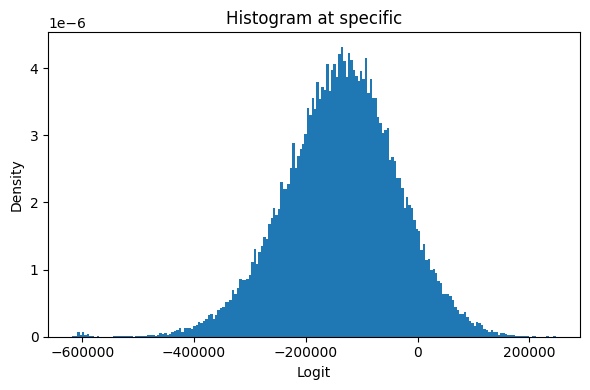

In [35]:
pos_logits = tensor[0, 483].detach().cpu().numpy()
plt.figure(figsize=(6,4))
plt.hist(pos_logits, bins=200, density=True)
plt.title("Histogram at specific")
plt.xlabel("Logit"); plt.ylabel("Density")
plt.tight_layout(); plt.show()

In [47]:
ce_from_logits_t(logits_1[0, 654, :], 200)

tensor(388079.1250)

In [43]:
ce_from_logits_t(logits_1[0, 655, :], 200)

tensor(465725.7188)

In [37]:
max_ids1

np.int64(655)

In [49]:
ce_from_logits_t(logits_1[0, -2, :], 351)

tensor(34639.8672)